In [1]:
import numpy as np
import matplotlib.pyplot as plt
import resfuncRead as rfr

In [2]:
#read the files (from anthony)
#ptres = rfr.getRFunc('data/jardin_ptres.txt')
#qres = rfr.getRFunc('data/jardin_qsummaxres.txt')

In [3]:
k = 0.157 # from lindhard
q = 1.602*10**-19 #electron charge 
V = 4.0 # voltage Bias
eps = 3.3

#for detector 1.

p_alpha = 0.155393
p_beta = 9.60343*10**(-11)
p_gamma = 0.000506287

q_alpha = 0.166004
q_beta = 0.00233716
q_gamma = 9.52576*10**(-5)

In [65]:
#x = np.arange(0,200,0.1)
#Er = 93*np.exp(-x/29) #For NR from Kennedy Thesis 

N = 10000
Er = np.random.exponential(40,np.uint32(N*0.3)) #tip from anthony 


ER = []
Yield = []
Ran = []
Yl= []
sig = []


In [66]:
#For Nuclear Recoils 
Fano = 1.4
N = 10000
for i in np.arange(0,N):
    
    Enr = np.random.choice(Er)
    Ran.append(Enr)
    
    sig_p = np.sqrt(p_alpha + p_beta*Enr + p_gamma*(Enr**2) + Fano**2) #Phonon uncertainty (energy dependent)
    sig_q = np.sqrt(q_alpha + q_beta*Enr + q_gamma*(Enr**2) + Fano**2) #Charge uncertainty 
    
    
    esp = 11.5*Enr*(23)**-(7/3)
    g = 3*esp**(0.15)+0.7*esp**(0.6)+esp
    Y = k*g/(1+k*g)
    
        
    #Ft = 1/np.sqrt(2*3.14*sig_p**2)*np.exp(-(x-(1+Y*(q*V/0.036))*Er)**2/2*sig_p**2)#equation 5.2
    Fnr = np.random.normal(0.0,sig_p) #random sample assuming phonon variance 

    #Fq = 1/np.sqrt(2*3.14*sig_q**2)*np.exp(-(x-0.3*Er)**2/2*sig_q**2)# equation 5.23
    Fq = np.random.normal(0.0,sig_q) #random sampel assuming charge variance 
    

    Ptnr = (Y*Enr*V)/eps + Enr #total phonon energy 
    Ptnr = Ptnr + Fnr 
    
    Qnr = Y*Enr
    Qnr1 = Qnr + Fq 
    
    
    Ernr = Ptnr - (V/eps)*Qnr1
    ER.append(Ernr)

    yield1 = Qnr1 / Ernr
    Yield.append(yield1)
    sig.append(sig_p)
    
    

1.8230819930240398


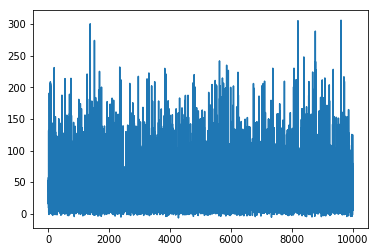

In [67]:
Yield_er = []
ERer = []
print(np.mean(sig))
plt.plot(ER)



In [68]:
#For Electron Recoils. 

#x = np.arange(0,2000,0.1)
#E1er = 82*np.exp(-x/304) #For ER from Kennedy Thesis
E1er = Eer = np.random.uniform(0,200,N) #from anthony, Er's are close enough to randomly distributed. 



for i in np.arange(10000):
    
    Eer = np.random.choice(E1er) #randomly sample from Energy dist 
    
    
    sig_p = np.sqrt(p_alpha + p_beta*Eer + p_gamma*(Eer**2)) #Phonon uncertainty 
    sig_q = np.sqrt(q_alpha + q_beta*Eer + q_gamma*(Eer**2)) #Charge uncertainty 

    Fer = np.random.normal(0.0,sig_p) #Random energy assuming phonon variance 
    Fqe = np.random.normal(0.0,sig_q) #Random assuming charge variane


    Pter = (1+(V/eps))*Eer 
    Pter = Pter + Fer
    Qer = Eer
    Qer = Qer + Fqe

    Erer = Pter - (V/eps)*Qer
    ERer.append(Erer)
    
    Yield2 = Qer/Erer
    Yield_er.append(Yield2)

In [69]:
# Make band Fits (Thank you Anthony)

# files contain fits from previous data. I believe that they are fits from real data. As seen, the model has a significantly narrower spread the fits 
# from the data 

bpar_er = rfr.getBandFunc('data/erband_R133') #reads in band data/fit for er data
bpar_nr = rfr.getBandFunc('data/nrband_R133') #reads in band data/fit for nr data 

yer_mu = rfr.makeBFunc(bpar_er[1]['mu']) # sets average fit from 1st (2nd) col in data table. 
yer_muv = np.vectorize(yer_mu) #puts mean data for er in 1D array 
yer_sig = rfr.makeBFunc(bpar_er[1]['sig'],True) #sets uncertainty 
yer_sigv = np.vectorize(yer_sig) #puts uncertainty into 1D array

#following does the same but for nuclear recoils. 
ynr_mu = rfr.makeBFunc(bpar_nr[1]['mu'])
ynr_muv = np.vectorize(ynr_mu)
ynr_sig = rfr.makeBFunc(bpar_nr[1]['sig'],True)
ynr_sigv = np.vectorize(ynr_sig)

# try new fit

xn = np.arange(0.1,100,0.1)
m, c = np.polyfit(ER, Yield, 1)
yn = np.polyval([m, c], xn)

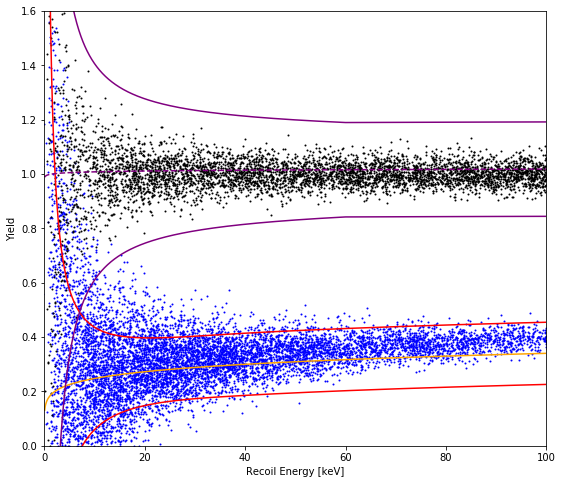

In [74]:
#plot 


fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes


X = np.arange(0.1,100,0.1)

ax1.plot(ER,Yield,'o',color='b',linewidth=2,markersize=1)
ax1.plot(ERer,Yield_er,'o',color='k',linewidth=2,markersize=1)

ax1.plot(X,ynr_muv(X),color = 'orange',label='NR mu') #using old data 
#ax1.plot(xn,yn,'r--') #new fit to data (mean)

ax1.plot(X,ynr_muv(X)+3*ynr_sigv(X),'r-',label='NR 3$\sigma$')
ax1.plot(X,ynr_muv(X)-3*ynr_sigv(X),'r-',label=None)

ax1.plot(X,yer_muv(X),color='purple',linestyle='--',label='ER mu')
ax1.plot(X,yer_muv(X)+3*yer_sigv(X),color='purple',linestyle='-',label='ER 3$\sigma$')
ax1.plot(X,yer_muv(X)-3*yer_sigv(X),color='purple',linestyle='-',label=None)

ax1.set_xlabel('Recoil Energy [keV]')
ax1.set_ylabel('Yield')
ax1.set_ylim(0,1.6)
ax1.set_xlim(0,100)


plt.show()


In [72]:
data = np.vstack((ER,Yield)).T
np.savetxt("test_data.txt",data)